# Evaluate inversion results

This notebook evaluates and plots the results of the joint inversion. <br>

**jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 15/05/2023**


#### Import library

In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

#### define inversion run

In [2]:
inv_run = 'VI_inversion_shifted_AntGG_residual_grav_gravmag_reg10_coupling_15e3_run2/'
inv_run1 = 'VI_inversion_shifted_AntGG_residual_grav_gravmag_reg10_coupling_25e3_run1/'

# inv_run = 'VI_inversion_shifted_AntGG_residual_grav_gravmag_reg10_coupling_25e3_run1/'


In [3]:
Topo_values_regridded_pd = pd.read_csv('DATA/exported_Topo_values_regridded.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'topo' ])
CDP_above_Moho_regridded_pd = pd.read_csv('DATA/exported_CDP_above_Moho_regridded.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'CDP_above_Moho' ])

Topo_values_regridded = Topo_values_regridded_pd.to_numpy()
CDP_above_Moho_regridded = CDP_above_Moho_regridded_pd.to_numpy()


study_area_pd = pd.read_csv('DATA/study_padding_area.txt', skiprows=1, 
                        names=['x_stu' , 'y_stu' , 'x_pad' , 'y_pad' ])

study_area = study_area_pd.to_numpy()

Coastline = pd.read_pickle('DATA/costline_wsb.pkl')
GHI_wsb = pd.read_pickle('DATA/GHI_wsb.pkl')


In [4]:
unit_dens = 'kg/m$^3$'
unit_sus = 'SI'

In [5]:
## load shifted data
shift_values_pd = pd.read_csv('DATA/exported_shift_value.txt', skiprows=1, names=['x_shift' , 'y_shift'])
shift_values = shift_values_pd.to_numpy()

###### Grav data ######
nc = nc4.Dataset(inv_run+'VI_inversion/gravdata.nc')  # grav data set
X_input_grav = nc.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_input_grav = nc.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates 
val_input_grav = nc.variables['Scalar_gravity'][:] *1e5  # gravity data converted from SI units to mGal
unit_grav = 'mGal'

##### Mag data ######
nc1 = nc4.Dataset(inv_run+'VI_inversion/magdata.nc')  # mag data set
X_input_mag = nc1.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_input_mag = nc1.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates
val_input_mag = nc1.variables['T'][:]   # magnetic data
unit_mag = 'nT'

##### Inverted Results ######
#### Grav ####
G = nc4.Dataset(inv_run+'VI_inversion/result.inv_sgd.nc')   # syn grav data set
X_syn_grav = G.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_syn_grav = G.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates 
val_syn_grav = G.variables['Scalar_gravity'][:]*1e5  # syn gravity data

diff_grav = val_input_grav - val_syn_grav  # difference observed and syn gravity data
diff_grav_pd = pd.DataFrame(diff_grav, columns = ['diff_grav'])
mxn_d=max(abs(max(diff_grav)),abs(min(diff_grav)))

#### Mag ####
G1 = nc4.Dataset(inv_run+'VI_inversion/result.inv_mag.nc')   # syn mag data set
X_syn_mag = G1.variables['MeasPosX'][:] - (shift_values[0,0]*2) # x coordinates
Y_syn_mag = G1.variables['MeasPosY'][:] - (shift_values[0,1]*2) # y coordinates
val_syn_mag = G1.variables['T'][:]       # syn magnetic data


diff_mag = val_input_mag - val_syn_mag   # difference observed and syn magnetic data
diff_mag_pd = pd.DataFrame(diff_mag, columns = ['diff_mag'])
mxn_mag=max(abs(max(diff_mag)),abs(min(diff_mag)))


VI_cov = nc4.Dataset(inv_run +'VI_inversion/MI_cov.nc') 
XX_mag_mesh = VI_cov.variables['Northing'][:]
YY_mag_mesh = VI_cov.variables['Easting'][:]
VI_cov_mesh = VI_cov.variables['Density'][:]

VI_cov.close()

nc.close()
nc1.close()
G.close()
G1.close()

In [6]:
# run2_misfit = np.genfromtxt(inv_run+'VI_inversion/misfit.out')
# run2_rms = np.genfromtxt(inv_run+'VI_inversion/rms.out')

# rms = run2_rms
# misfit = run2_misfit


max grav error : 36.6 mGal
min grav error : -18.4 mGal
mean grav error : 0.1 mGal
std grav error : 2.9 mGal 

max mag error : 340.9 nT
min mag error : -64.5 nT
mean mag error : -1.3 nT
std mag error : 13.1 nT 



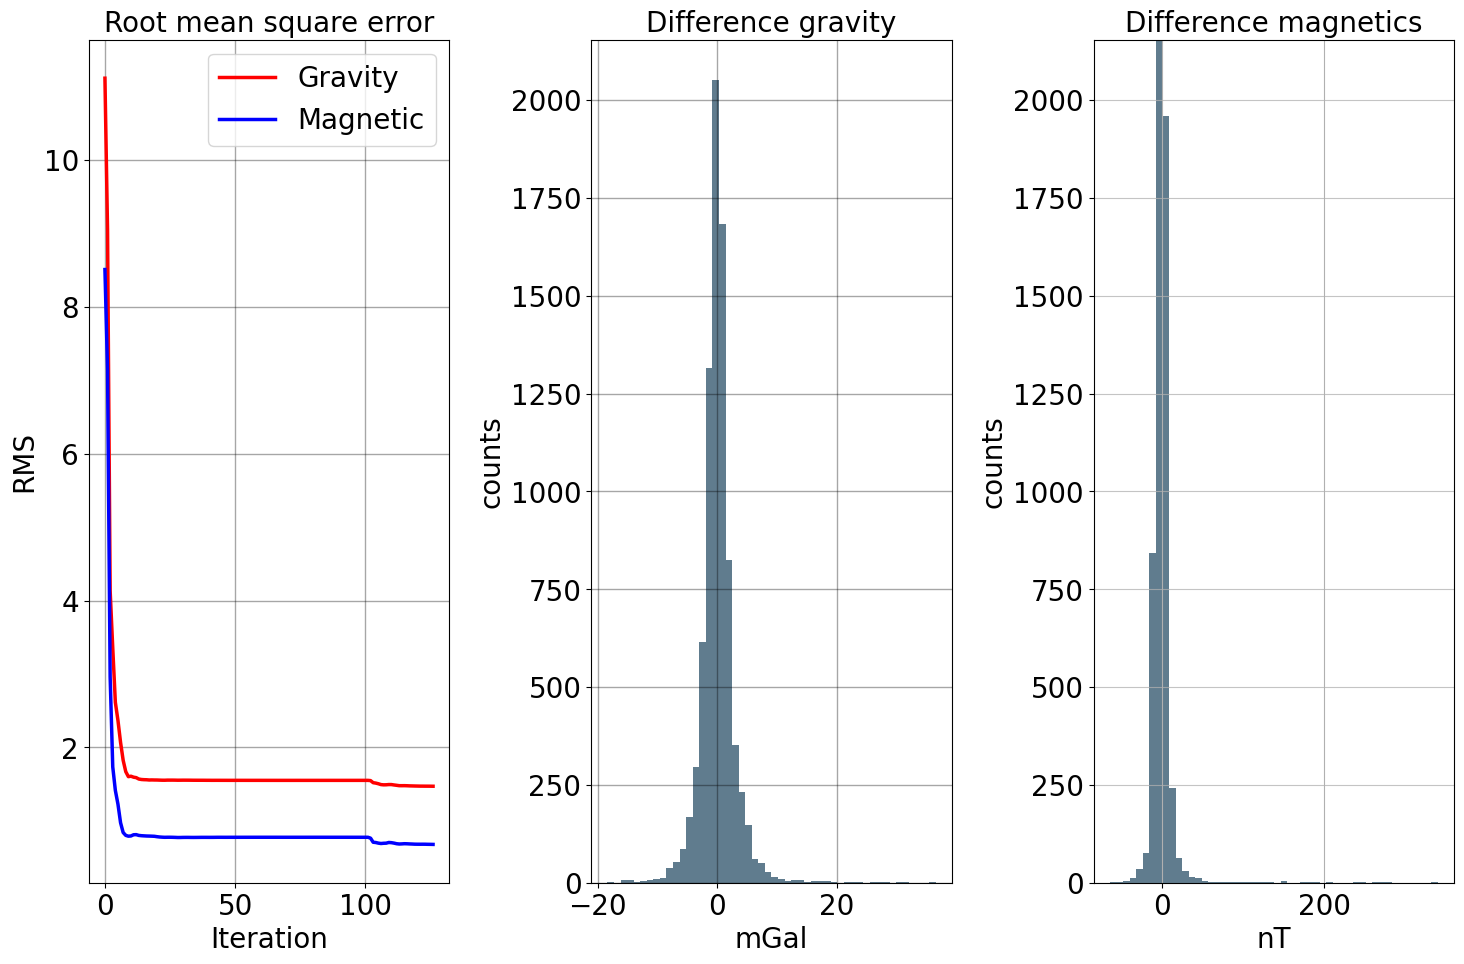

In [7]:
# load missift and rms data 

run1_misfit = np.genfromtxt(inv_run1+'VI_inversion/misfit.out')
run1_rms = np.genfromtxt(inv_run1+'VI_inversion/rms.out')

run2_misfit = np.genfromtxt(inv_run+'VI_inversion/misfit.out')
run2_rms = np.genfromtxt(inv_run+'VI_inversion/rms.out')

rms = np.concatenate((run1_rms, run2_rms), axis=0)
misfit = np.concatenate((run1_misfit, run2_misfit), axis=0)


figure1, axs = plt.subplots(1, 3, figsize=(15,10),facecolor='white')

axs[0].plot(rms[:,1] , '-r' , linewidth=2.5 , label='Gravity')
axs[0].plot(rms[:,2] , '-b' , linewidth=2.5 , label='Magnetic')
axs[0].legend(loc='upper right' , prop={'size': 20})
axs[0].set_title("Root mean square error" , fontsize=20)
axs[0].set_xlabel('RMS', fontsize=20)
axs[0].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[0].set_xlabel('Iteration' , fontsize=20)
axs[0].set_ylabel('RMS' , fontsize=20)
axs[0].tick_params(axis="x", labelsize=20) 
axs[0].tick_params(axis="y", labelsize=20) 


diff_grav_pd.diff_grav.plot.hist(grid=True, bins=50 , ax=axs[1] ,  color='#607c8e')
axs[1].set_title('Difference gravity', fontsize=20)
axs[1].set_xlabel('mGal', fontsize=20)
axs[1].set_ylabel('counts', fontsize=20)
axs[1].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[1].tick_params(axis="x", labelsize=20) 
axs[1].tick_params(axis="y", labelsize=20) 



diff_mag_pd.diff_mag.plot.hist(grid=True, bins=50 , ax=axs[2] ,  color='#607c8e')
axs[2].set_title('Difference magnetics' , fontsize=20)
axs[2].set_xlabel('nT', fontsize=20)
axs[2].set_ylabel('counts', fontsize=20)
axs[2].sharey(axs[1])
axs[2].grid(axis='y', alpha=0.75)
axs[2].tick_params(axis="x", labelsize=20) 
axs[2].tick_params(axis="y", labelsize=20) 


figure1.tight_layout(pad=2)

# plt.savefig(export_fig_path + 'inversion_stats.png',facecolor=figure1.get_facecolor(), transparent=True)



print("max grav error :", '{0:.1f}'.format(np.max(diff_grav)) , "mGal")
print("min grav error :", '{0:.1f}'.format(np.min(diff_grav)) , "mGal"),
print("mean grav error :", '{0:.1f}'.format(np.mean(diff_grav)) , "mGal")
print("std grav error :", '{0:.1f}'.format(np.std(diff_grav)) , "mGal \n")

print("max mag error :", '{0:.1f}'.format(np.max(diff_mag)) , "nT")
print("min mag error :", '{0:.1f}'.format(np.min(diff_mag)) , "nT"),
print("mean mag error :", '{0:.1f}'.format(np.mean(diff_mag)) , "nT")
print("std mag error :", '{0:.1f}'.format(np.std(diff_mag)) , "nT \n")



In [8]:
#read in magnetic inversion model
mag_fh = Dataset(inv_run+"VI_inversion/result.mag.inv.nc")
X_sus = mag_fh.variables["Northing"][:] - (shift_values[0,0]*2)
Y_sus =mag_fh.variables["Easting"][:] - (shift_values[0,1]*2)
Depth_sus =mag_fh.variables["Depth"][:]
X_sus_Origin =mag_fh.variables["Northing_Origin"][:] - (shift_values[0,0]*2)
Y_sus_Origin =mag_fh.variables["Easting_Origin"][:] - (shift_values[0,1]*2)
Depth_sus_Origin =mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

#and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset(inv_run+"VI_inversion/result.grav.inv.nc")
inv_dens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()

In [9]:
xq , yq = np.meshgrid(X_sus , Y_sus)
Depth_inversion_km = np.round((Depth_sus/1000),1)

In [10]:
line_x = (min(xq[0,:])  , max(xq[0,:]))
line_y = (yq[74,0] , yq[74,0])
line_y

(-1741429.7034642603, -1741429.7034642603)

Text(0.5, 1.0, 'nT')

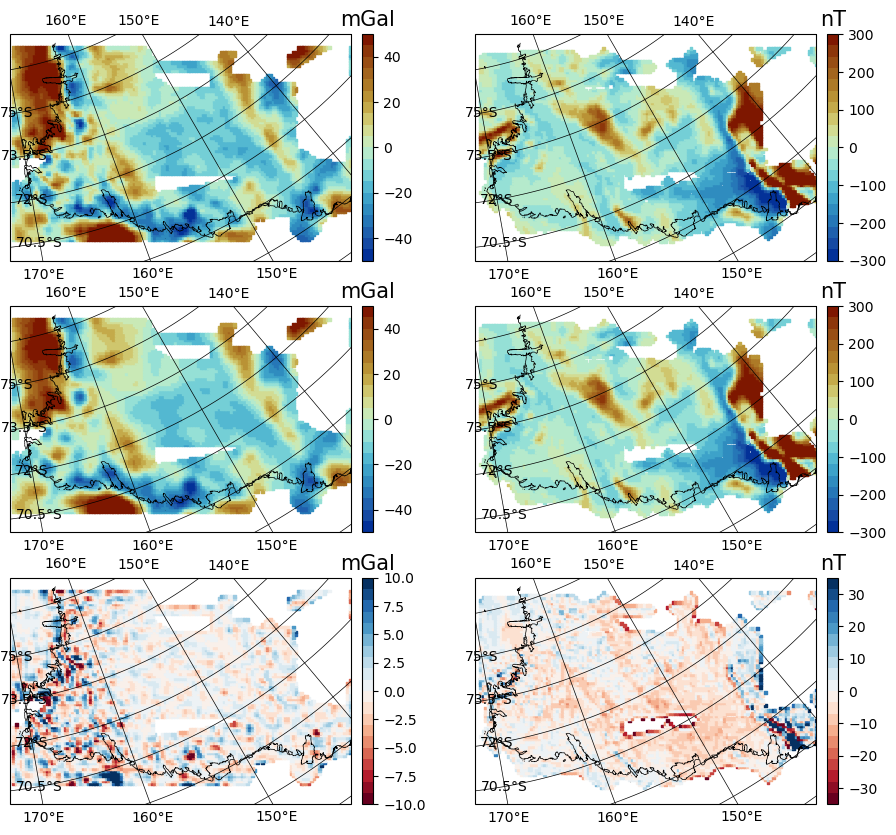

In [11]:
m=15 #fontsize
cmap = cm.roma_r.resampled(20)
cmap_rev = cm.roma_r.resampled(20)
cmap_grav_diff = plt.get_cmap('RdBu',20)


line_x = (0.25e6 , 1.6e6)
line_y = (-1741429 , -1741429)


figure1 = plt.figure(figsize=(11,10),facecolor='white')
# fig.tight_layout()


ax1 = plt.subplot(3, 2, 1 , projection=ccrs.SouthPolarStereo())
ax1.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
im = plt.scatter(X_input_grav , Y_input_grav , c=val_input_grav , marker='s', s=4, cmap = cmap_rev, vmin=-50, vmax=50 ,
                 transform=ccrs.SouthPolarStereo())
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb1 = plt.colorbar(im, cax=cax)
cb1.ax.set_title(unit_grav,fontsize=m)
    
ax2 = plt.subplot(3, 2, 3 , projection=ccrs.SouthPolarStereo())
ax2.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im2 = plt.scatter(X_syn_grav , Y_syn_grav , c=val_syn_grav, marker='s', s=4, cmap =cmap_rev , vmin=-50, vmax=50 ,
                  transform=ccrs.SouthPolarStereo())
Coastline.plot(ax=ax2 , color = 'k' , linewidth = 0.5)
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb2 = plt.colorbar(im2, cax=cax)
cb2.ax.set_title(unit_grav,fontsize=m)


ax3 = plt.subplot(3, 2, 5 , projection=ccrs.SouthPolarStereo())
ax3.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im3 = plt.scatter(X_input_grav , Y_input_grav , c=diff_grav , marker='s' , s=4 , cmap=cmap_grav_diff ,
                  vmin=-10 , vmax=10 , transform=ccrs.SouthPolarStereo()) #, vmin=-mxn_d/10, vmax=mxn_d/10)
Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
ax3.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb3 = plt.colorbar(im3, cax=cax)
cb3.ax.set_title(unit_grav,fontsize=m)


ax4 = plt.subplot(3, 2, 2 , projection=ccrs.SouthPolarStereo())
ax4.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im4 = plt.scatter(X_input_mag , Y_input_mag , c=val_input_mag , marker='s', s=4 , cmap =cmap , vmin=-300 , vmax=300 ,
                  transform=ccrs.SouthPolarStereo())
Coastline.plot(ax=ax4 , color = 'k' , linewidth = 0.5)
ax4.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb4 = plt.colorbar(im4, cax=cax)
cb4.ax.set_title(unit_mag,fontsize=m)


ax5 = plt.subplot(3, 2, 4 , projection=ccrs.SouthPolarStereo())
ax5.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im5 = plt.scatter(X_syn_mag , Y_syn_mag , c=val_syn_mag , marker='s', s=4 , cmap =cmap , vmin=-300 , vmax=300 ,
                  transform=ccrs.SouthPolarStereo())
Coastline.plot(ax=ax5 , color = 'k' , linewidth = 0.5)
ax5.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb5 = plt.colorbar(im5, cax=cax)
cb5.ax.set_title(unit_mag,fontsize=m)


ax6 = plt.subplot(3, 2, 6 , projection=ccrs.SouthPolarStereo())
ax6.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
cmap= plt.get_cmap('RdBu',20)
im6 = plt.scatter(X_input_mag , Y_input_mag , c=diff_mag , marker='s', s=4 , cmap=cmap_grav_diff  , vmin=-35, vmax=35 ,
                  transform=ccrs.SouthPolarStereo())
Coastline.plot(ax=ax6 , color = 'k' , linewidth = 0.5)
ax6.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb6 = plt.colorbar(im6, cax=cax)
cb6.ax.set_title(unit_mag,fontsize=m)


# plt.savefig(inv_run+'Output/Figure/VI_inversion_maps_with_profil_location.png',facecolor=figure1.get_facecolor(), transparent=True)


## Plot inverted density and susceptibility values

#### load sussceptibility and density values

In [12]:
#read in magnetic inversion model
mag_fh = Dataset(inv_run+"VI_inversion/result.mag.inv.nc")
X_sus = mag_fh.variables["Northing"][:] - (shift_values[0,0]*2)
Y_sus =mag_fh.variables["Easting"][:] - (shift_values[0,1]*2)
Depth_sus =mag_fh.variables["Depth"][:]
X_sus_Origin =mag_fh.variables["Northing_Origin"][:] - (shift_values[0,0]*2)
Y_sus_Origin =mag_fh.variables["Easting_Origin"][:] - (shift_values[0,1]*2)
Depth_sus_Origin =mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

#and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset(inv_run+"VI_inversion/result.grav.inv.nc")
inv_dens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()

## Plot horizontal depth slice

#### grid x y cooridnates, convert m to km

In [13]:
xq , yq = np.meshgrid(X_sus , Y_sus)
Depth_inversion_km = np.round((Depth_sus/1000),1)

#### loop over every depth intervall to plot depth slices

Text(0.5, 1.0, 'SI')

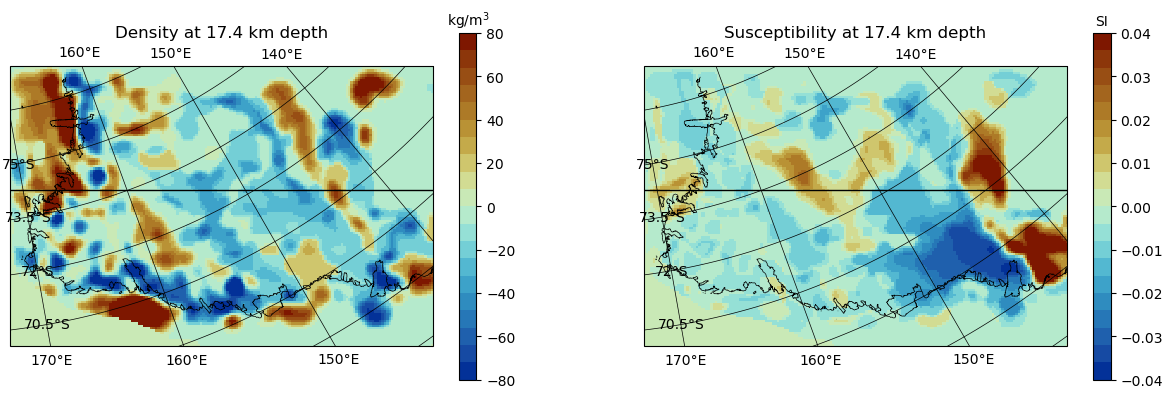

In [14]:
Depth_index = 11  # Choose depth invervall between 0 and 20 relating to the inversion depths (-3000. -1900.  -690.   641.  2105. 3716.  5488.  7437.  9581. 11939. 14533. 17386. 20524. 23976. 27773. 31950. 36545. 41599. 47159. 53275. 60002. [m])
    
    
figure1 = plt.figure(figsize=(15,15),facecolor='white')

inv_dens_depth_slice = inv_dens[Depth_index,:,:]
inv_sus_depth_slice = inv_sus[Depth_index,:,:]

ax3 = plt.subplot(1, 2, 1 , projection=ccrs.SouthPolarStereo())
plt.title("Density at {:.1f} km depth".format(Depth_inversion_km[Depth_index]))
ax3.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im3 = plt.pcolormesh(xq , yq ,inv_dens_depth_slice , cmap = cmap_rev, vmin=-80 , vmax = 80)
Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
ax3.plot(line_x , line_y , color='k' , linewidth=1)
ax3.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cb = plt.colorbar(im3, shrink=0.3)
cb.ax.set_title(unit_dens,fontsize=10)



ax4 = plt.subplot(1, 2, 2 , projection=ccrs.SouthPolarStereo())
plt.title("Susceptibility at {:.1f} km depth".format(Depth_inversion_km[Depth_index]))
ax4.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
im4 = plt.pcolormesh(xq , yq ,inv_sus_depth_slice , cmap = cmap_rev  , vmin=-0.04 , vmax = 0.04 )
Coastline.plot(ax=ax4 , color = 'k' , linewidth = 0.5)
ax4.plot(line_x , line_y , color='k' , linewidth=1)
ax4.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cb = plt.colorbar(im4, shrink=0.3)
cb.ax.set_title(unit_sus,fontsize=10)

## Plot vertical profil slice

In [15]:
x_max_inv = max(X_syn_grav)
x_min_inv = min(X_syn_grav)
y_max_inv = max(Y_syn_grav)
y_min_inv = min(Y_syn_grav)

profil_numbers = np.arange(18,120,1)

In [16]:
Moho4profile_data_pd = pd.read_csv('DATA/Moho_depth4profile.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'Moho'])
Moho4profile_data = Moho4profile_data_pd.to_numpy()

CDP4profile_data_pd = pd.read_csv('DATA/CDP_depth4profile.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'CDP_above_Moho'])
CDP4profile_data = CDP4profile_data_pd.to_numpy()

Topo4profile_data_pd = pd.read_csv('DATA/Topo_depth4profile.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'Topo'])
Topo4profile_data = Topo4profile_data_pd.to_numpy()


x_moho_profil_grid = np.reshape(Moho4profile_data[:,0]- (shift_values[0,0]*2),(xq.shape[0],xq.shape[1]))
y_moho_profil_grid = np.reshape(Moho4profile_data[:,1]- (shift_values[0,1]*2),(xq.shape[0],xq.shape[1]))
z_moho_profil_grid = np.reshape(Moho4profile_data[:,2],(xq.shape[0],xq.shape[1]))

x_cdp_profil_grid = np.reshape(CDP4profile_data[:,0]- (shift_values[0,0]*2),(xq.shape[0],xq.shape[1]))
y_cdp_profil_grid = np.reshape(CDP4profile_data[:,1]- (shift_values[0,1]*2),(xq.shape[0],xq.shape[1]))
z_cdp_profil_grid = np.reshape(CDP4profile_data[:,2],(xq.shape[0],xq.shape[1]))

x_topo_profil_grid = np.reshape(Topo4profile_data[:,0]- (shift_values[0,0]*2),(xq.shape[0],xq.shape[1]))
y_topo_profil_grid = np.reshape(Topo4profile_data[:,1]- (shift_values[0,1]*2),(xq.shape[0],xq.shape[1]))
z_topo_profil_grid = np.reshape(Topo4profile_data[:,2],(xq.shape[0],xq.shape[1]))

In [17]:
Obsevered_grav =  np.vstack((np.round(X_input_grav) , np.round(Y_input_grav) , val_input_grav)).T
Synthetic_grav =  np.vstack((np.round(X_syn_grav) , np.round(Y_syn_grav) , val_syn_grav)).T
Obsevered_mag =  np.vstack((np.round(X_input_mag) , np.round(Y_input_mag) , val_input_mag)).T
Synthetic_mag =  np.vstack((np.round(X_syn_mag) , np.round(Y_syn_mag) , val_syn_mag)).T


In [18]:
x_profil , z_profil = np.meshgrid(X_sus,Depth_sus)


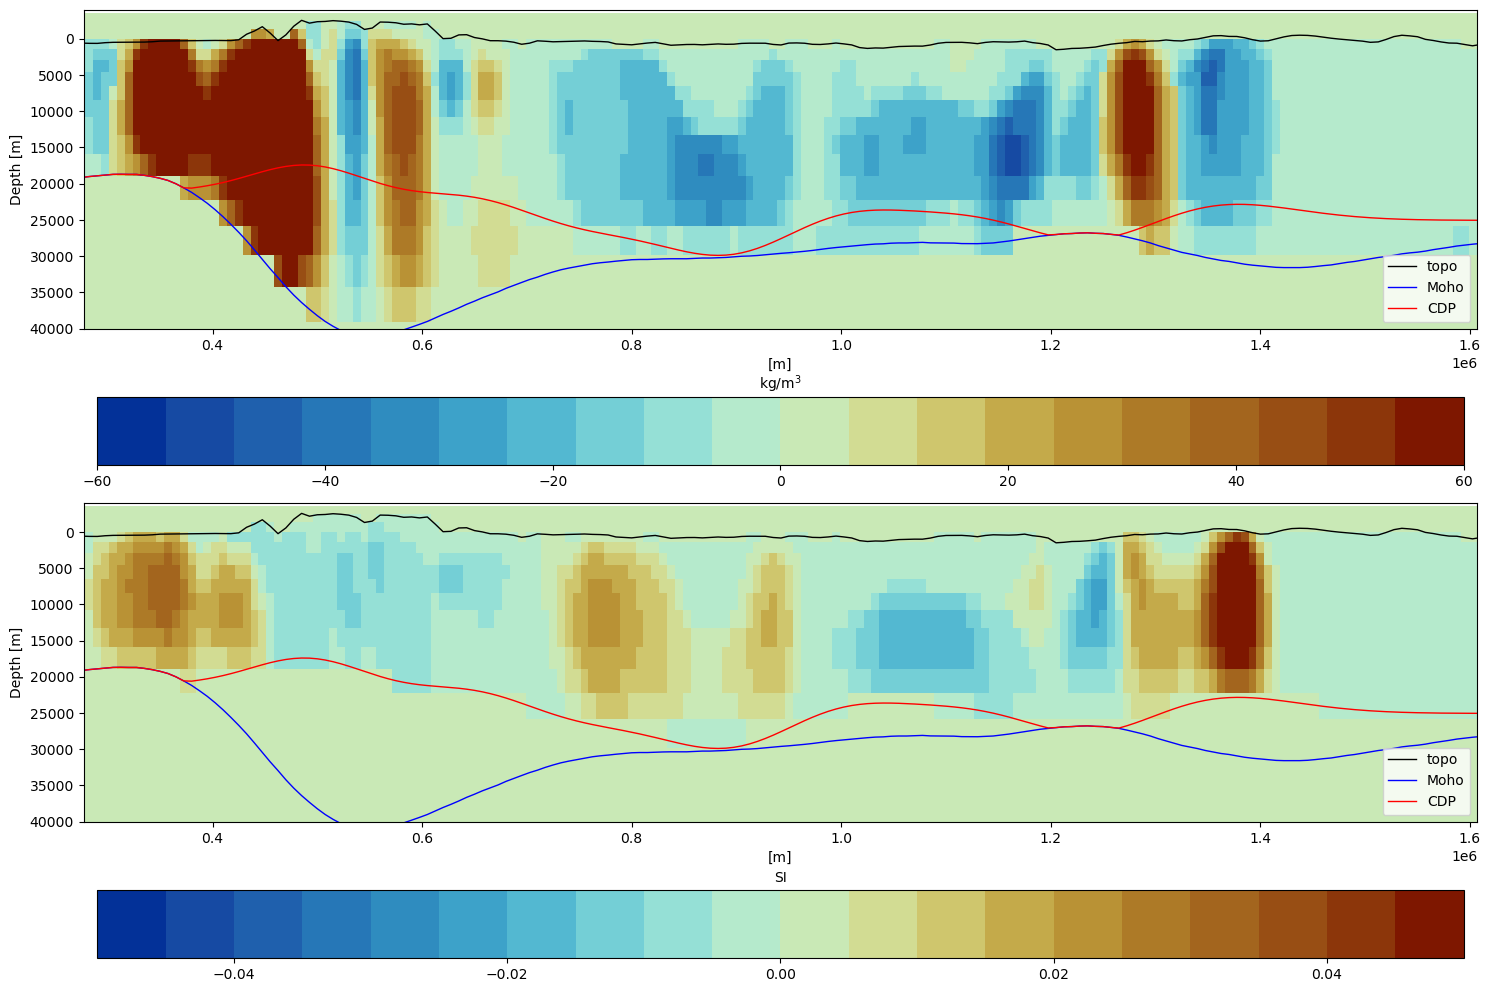

In [19]:

# define fontsize
fontsize_index = 10

y_direction_index = 75
    
sus_profil_ix = inv_sus[:,y_direction_index,:]
dens_profil_ix = inv_dens[:,y_direction_index,:]

## find moho and cdp profile line for current loop run
x_moho_profil_line_data = x_moho_profil_grid[y_direction_index , :]
z_moho_profil_line_data = z_moho_profil_grid[y_direction_index , :]
x_cdp_profil_line_data = x_cdp_profil_grid[y_direction_index , :]
z_cdp_profil_line_data = z_cdp_profil_grid[y_direction_index , :]
x_topo_profil_line_data = x_topo_profil_grid[y_direction_index , :]
z_topo_profil_line_data = z_topo_profil_grid[y_direction_index , :]

   
## plot figure
figure1 = plt.figure(figsize = (15,10),facecolor='white')
spec = figure1.add_gridspec(2, 2)

# plot density profil
ax1 = figure1.add_subplot(spec[0, :])
im1 = plt.pcolormesh(x_profil , z_profil , dens_profil_ix , cmap=cmap_rev , vmin=-60 , vmax=60 , shading='auto')
plt.plot(x_topo_profil_line_data,z_topo_profil_line_data , color='black',linewidth=1 , label='topo')
plt.plot(x_moho_profil_line_data,z_moho_profil_line_data , color='blue',linewidth=1 , label='Moho')
plt.plot(x_cdp_profil_line_data,z_cdp_profil_line_data , color='red',linewidth=1 , label='CDP')
ax1.legend(loc='lower right' ,  prop={'size': 10})
plt.xlabel('[m]', fontsize=fontsize_index)
plt.ylabel('Depth [m]' , fontsize=fontsize_index)
ax1.set_ylim([-4000 , 40000])
ax1.set_xlim([min(study_area[:,0]), max(study_area[:,0])])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im1 , shrink=1 , orientation='horizontal')
cb.ax.set_title(unit_dens ,fontsize=fontsize_index)

# plot sus profil
ax2 = figure1.add_subplot(spec[1, :])
im2 = plt.pcolormesh(x_profil , z_profil , sus_profil_ix , cmap=cmap_rev , vmin=-0.05 , vmax=0.05 , shading='auto')
plt.plot(x_topo_profil_line_data,z_topo_profil_line_data , color='black',linewidth=1 , label='topo')
plt.plot(x_moho_profil_line_data,z_moho_profil_line_data , color='blue',linewidth=1 , label='Moho')
plt.plot(x_cdp_profil_line_data,z_cdp_profil_line_data , color='red',linewidth=1 , label='CDP')
ax2.legend(loc='lower right' ,  prop={'size': 10})
plt.xlabel('[m]', fontsize=fontsize_index)
plt.ylabel('Depth [m]' , fontsize=fontsize_index)
ax2.set_ylim([-4000 , 40000])
ax2.set_xlim([min(study_area[:,0]), max(study_area[:,0])])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2 , shrink=1 , orientation='horizontal')
cb.ax.set_title(unit_sus ,fontsize=fontsize_index)

figure1.tight_layout(pad=1)
            
           

# Density susceptibility relationship

In [20]:
export_data_path = inv_run + 'Output/Data/'

# Create path if it does not exists
if not os.path.exists(export_data_path):
    os.makedirs(export_data_path)

In [21]:
xq , yq = np.meshgrid(X_sus , Y_sus)
# Depth_inversion_km = np.round((Depth_sus/1000),1)
Depth_inversion_km = Depth_sus/1000

In [22]:
d= np.zeros(np.shape(inv_dens))
depths =  np.append(Depth_sus_Origin,Depth_sus)
for i in range(len(d)):
    d[i]=depths[i]/1000

In [23]:
x_stack_ix = []
y_stack_ix = []
z_stack_ix = []

for i in range(len(Depth_inversion_km)):
    
    x_stack_ix.append(xq)
    y_stack_ix.append(yq)
    
    z_stack_zeros = np.zeros((len(xq[:,0]), len(xq[0,:])))
    z_stack_zeros[:,:] = Depth_inversion_km[i]*1000
    z_stack_ix.append(z_stack_zeros)
    
x_stack = np.array(x_stack_ix)
y_stack = np.array(y_stack_ix)
z_stack = np.array(z_stack_ix)

In [24]:
crossplot_data =  np.vstack((inv_sus.flatten() , inv_dens.flatten() , x_stack.flatten() , y_stack.flatten() ,
                             z_stack.flatten() , VI_cov_mesh.flatten())).T

In [25]:
crossplot_data_cleaned_ix = []

for i in range(len(crossplot_data[:,0])):
    if crossplot_data[i,5] == 1:
        crossplot_data_cleaned_ix.append(crossplot_data[i,:])
crossplot_data_cleaned = np.array(crossplot_data_cleaned_ix)        

In [26]:
crossplot_data_cleaned_study_area_ix = []
for i in range(len(crossplot_data_cleaned[:,0])):
    if (crossplot_data_cleaned[i,2]> study_area[0,0] and crossplot_data_cleaned[i,2]< study_area[1,0] 
       and crossplot_data_cleaned[i,3]> study_area[0,1] and crossplot_data_cleaned[i,3]< study_area[2,1]):
        crossplot_data_cleaned_study_area_ix.append(crossplot_data_cleaned[i,:])
crossplot_data_cleaned_study_area = np.array(crossplot_data_cleaned_study_area_ix)

In [27]:
crossplot_data_cleaned = []
crossplot_data_cleaned = crossplot_data_cleaned_study_area
np.savetxt(export_data_path + "crossplot_data_cleaned.txt", crossplot_data_cleaned , delimiter=',')

Text(0.5, 1.0, 'km')

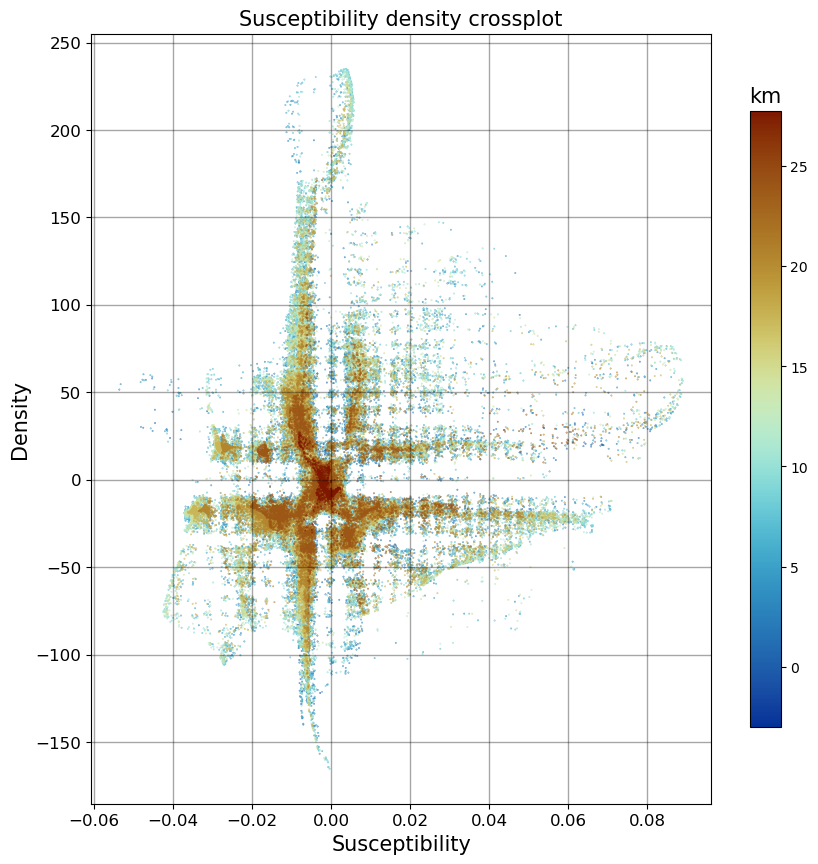

In [28]:
cmap = cm.roma_r

# create figure
figure1 = plt.figure(figsize=(10,10) , facecolor='white')

ax1 = plt.subplot(1, 1, 1)
im1 = plt.scatter(crossplot_data_cleaned[:,0],crossplot_data_cleaned[:,1] , 0.1 , c=crossplot_data_cleaned[:,4]/1000 , cmap=cmap)
ax1.set_title("Susceptibility density crossplot", fontsize=15)
ax1.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax1.set_xlabel('Susceptibility' , fontsize=15)
ax1.set_ylabel('Density' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


cb = plt.colorbar(im1 , orientation='vertical' , shrink=.8)
cb.ax.set_title("km",fontsize=15)


Text(0.5, 0, 'counts')

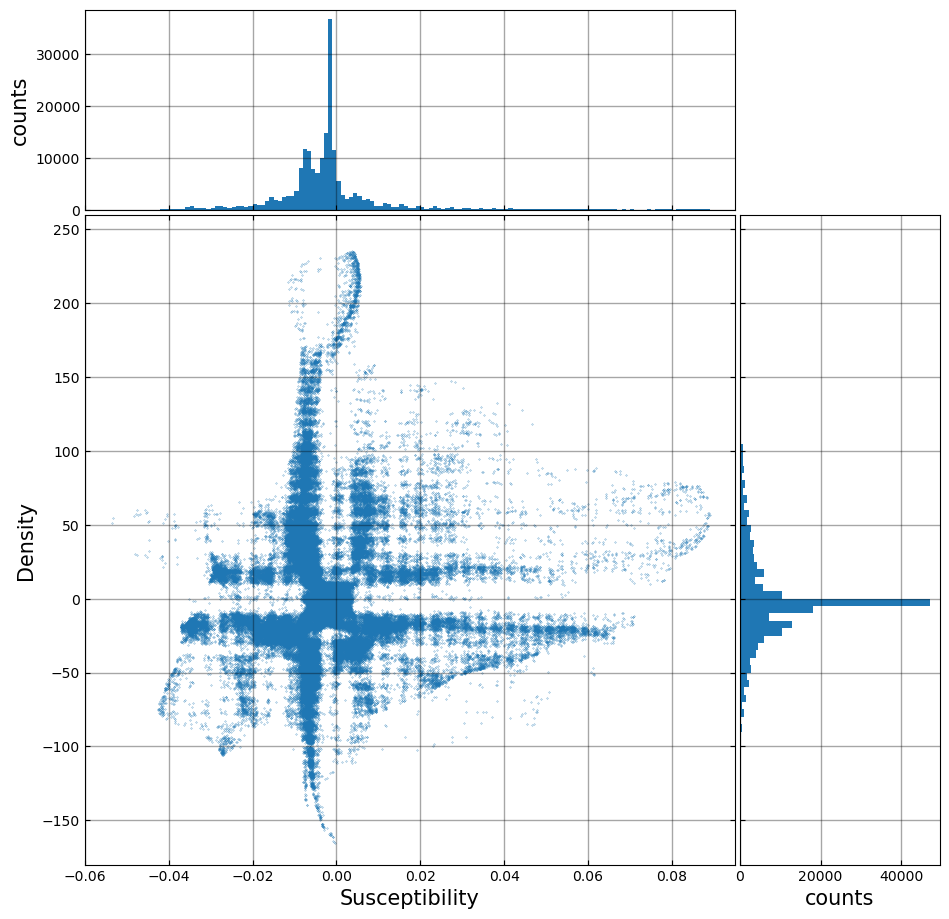

In [29]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10,10) , facecolor='white')


ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(crossplot_data_cleaned[:,0],crossplot_data_cleaned[:,1] , 0.05)
ax_scatter.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax_scatter.set_xlabel('Susceptibility' , fontsize=15)
ax_scatter.set_ylabel('Density' , fontsize=15)
ax_scatter.set_xlim((-0.06, 0.095)) 
ax_scatter.set_ylim((-180, 260))


# x histogramm
x_binwidth = 0.001  # bin size
x_bins = np.arange(-0.06, 0.095 + x_binwidth, x_binwidth) # set histogramm bin limes to scatter limites
ax_histx.hist(crossplot_data_cleaned[:,0], bins=x_bins) # histogramm plot
ax_histx.set_xlim(ax_scatter.get_xlim())  # set limites to scatter limites
ax_histx.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax_histx.set_ylabel('counts' , fontsize=15)

# y histo 
y_binwidth = 5 # bin size
y_bins = np.arange(-180, 260 + y_binwidth, y_binwidth) # set histogramm bin limes to scatter limites
ax_histy.hist(crossplot_data_cleaned[:,1], bins=y_bins , orientation='horizontal') # histogramm plot
ax_histy.set_ylim(ax_scatter.get_ylim()) # set limites to scatter limites
ax_histy.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax_histy.set_xlabel('counts' , fontsize=15)


## Extract 3D features

In [30]:
polygon1 = [[0.54e6 , -1.62e6],
            [0.87e6 , -1.86e6],
            [0.95e6 , -1.83e6],
            [0.73e6 , -1.6e6]]
polygon1.append(polygon1[0]) #repeat the first point to create a 'closed loop'
polygon1_x, polygon1_y = zip(*polygon1) #create lists of x and y values

polygon2 = [[1.04e6 , -1.46e6],
            [1.38e6 , -1.9e6],
            [1.4e6 , -1.85e6],
            [1.120e6 , -1.38e6]]
polygon2.append(polygon2[0]) #repeat the first point to create a 'closed loop'
polygon2_x, polygon2_y = zip(*polygon2) #create lists of x and y values


poly1 = Polygon(polygon1)
poly2 = Polygon(polygon2)


inverted_data_poly1_ix = []
inverted_data_poly2_ix = []


for c in range(len(Depth_inversion_km)):
    inverted_data_depth_slices = np.vstack((xq.flatten() , yq.flatten() , inv_dens[5].flatten() , inv_sus[5].flatten())).T

    for i in range(len(inverted_data_depth_slices[:,0])):
        points_ix = Point(inverted_data_depth_slices[i,0] , inverted_data_depth_slices[i,1])
        if points_ix.within(poly1) == True:
            data_within_poly1_ix = inverted_data_depth_slices[i,:]
            inverted_data_poly1_ix.append(data_within_poly1_ix)

    inverted_data_poly1 = np.array(inverted_data_poly1_ix)


    d_slice_data_cleaned_ix2 = []

    for i in range(len(inverted_data_depth_slices[:,0])):
        points_ix = Point(inverted_data_depth_slices[i,0] , inverted_data_depth_slices[i,1])
        if points_ix.within(poly2) == True:
            data_within_poly2_ix = inverted_data_depth_slices[i,:]
            inverted_data_poly2_ix.append(data_within_poly2_ix)

    inverted_data_poly2 = np.array(inverted_data_poly2_ix)
    print(c)
    
poly_1_sus_mean = np.mean(inverted_data_poly1[:,3])
poly_1_dens_mean = np.mean(inverted_data_poly1[:,2])
poly_1_sus_std = np.std(inverted_data_poly1[:,3])
poly_1_dens_std = np.std(inverted_data_poly1[:,2])

poly_2_sus_mean = np.mean(inverted_data_poly2[:,3])
poly_2_dens_mean = np.mean(inverted_data_poly2[:,2])
poly_2_sus_std = np.std(inverted_data_poly2[:,3])
poly_2_dens_std = np.std(inverted_data_poly2[:,2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


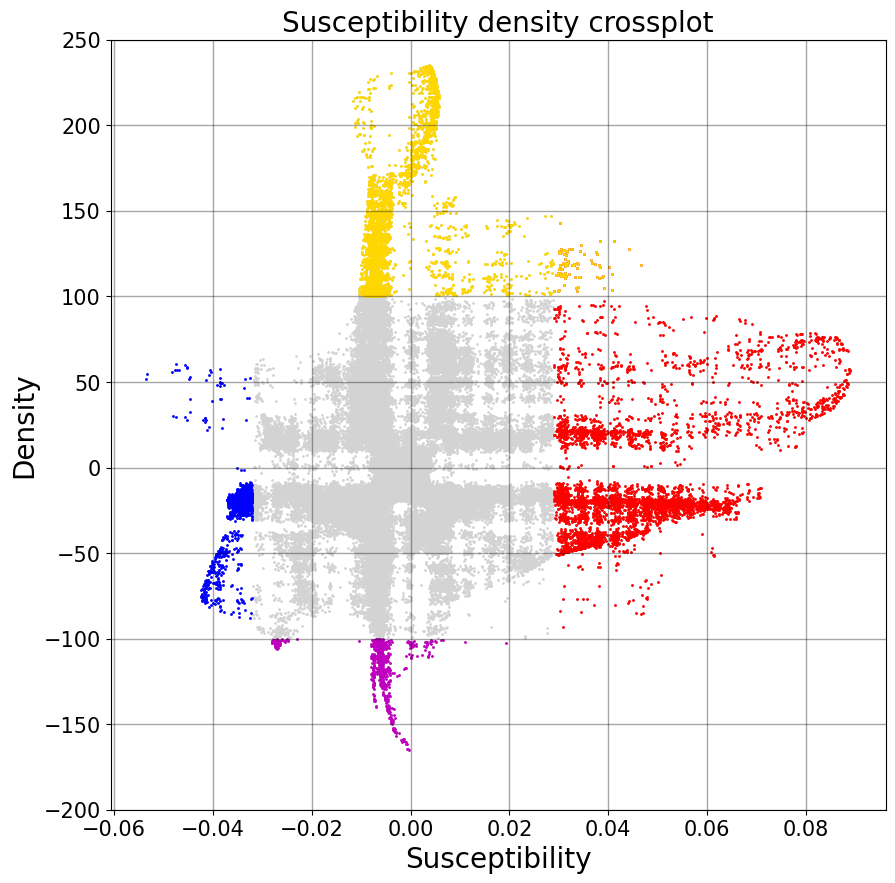

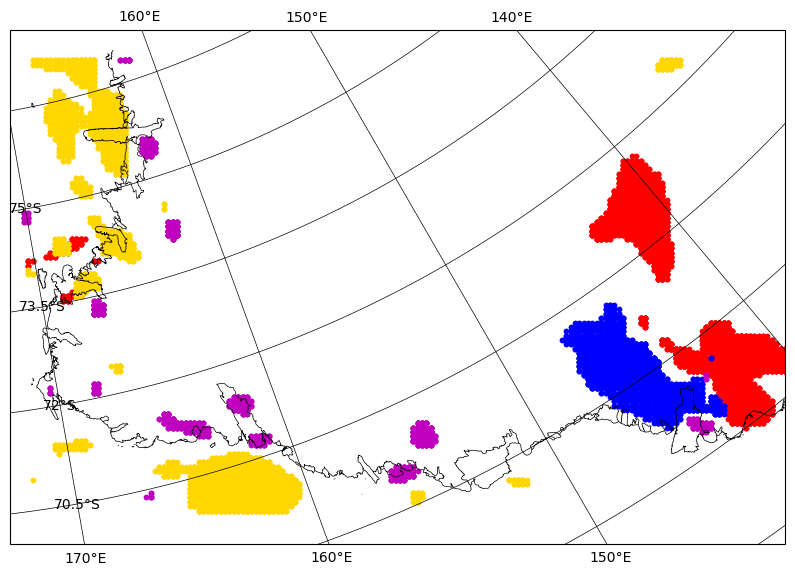

In [31]:
cmap = cm.roma_r
m = 15


# crossplot_data_cleaned_study_area: inv_sus _inv_dens x_ps y_ps z_ps MI_cov_mesh
position_high_sus_ix = []

for i in range(len(crossplot_data_cleaned_study_area[:,0])):
    if crossplot_data_cleaned_study_area[i,0] >= 0.029:
        position_high_sus_ix.append(crossplot_data_cleaned_study_area[i,:])
position_high_sus = np.array(position_high_sus_ix)


position_low_sus_ix = []

for i in range(len(crossplot_data_cleaned_study_area[:,0])):
    if crossplot_data_cleaned_study_area[i,0] <= -0.032:
        position_low_sus_ix.append(crossplot_data_cleaned_study_area[i,:])
position_low_sus = np.array(position_low_sus_ix)


position_high_density_ix = []

for i in range(len(crossplot_data_cleaned_study_area[:,0])):
    if crossplot_data_cleaned_study_area[i,1] >= 100:
        position_high_density_ix.append(crossplot_data_cleaned_study_area[i,:])
position_high_density = np.array(position_high_density_ix)


position_low_density_ix = []

for i in range(len(crossplot_data_cleaned_study_area[:,0])):
    if crossplot_data_cleaned_study_area[i,1] <= -100:
        position_low_density_ix.append(crossplot_data_cleaned_study_area[i,:])
position_low_density = np.array(position_low_density_ix)


# create figure
figure1 = plt.figure(figsize=(10,10) , facecolor='white')

ax1 = plt.subplot(1, 1, 1)
ax1.scatter(crossplot_data_cleaned[:,0],crossplot_data_cleaned[:,1] , 1 ,'lightgrey')
ax1.scatter(position_high_sus[:,0],position_high_sus[:,1] , 1 , 'r' )
ax1.scatter(position_low_sus[:,0],position_low_sus[:,1] , 1 , 'b')

ax1.scatter(position_high_density[:,0],position_high_density[:,1] , 1 , 'gold')
ax1.scatter(position_low_density[:,0],position_low_density[:,1] , 1 , 'm')
ax1.set_title("Susceptibility density crossplot", fontsize=20)
ax1.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax1.set_xlabel('Susceptibility' , fontsize=20)
ax1.set_ylabel('Density' , fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# ax1.set_xlim(-0.1, 0.1)
ax1.set_ylim(-200, 250)



figure2 = plt.figure(figsize=(10,10) , facecolor='white')
ax2 = plt.subplot(1, 1, 1 ,  projection=ccrs.SouthPolarStereo())
# Im = plt.scatter(X_input_mag , Y_input_mag , 12 , c=val_input_mag ,cmap =cmap , vmin=-300 , vmax=300 ,
#                   transform=ccrs.SouthPolarStereo())
# plt.title('inverted gravity anomaly',fontsize=m)
ax2.scatter(position_high_sus[:,2] , position_high_sus[:,3] , 10 , c='r',transform=ccrs.SouthPolarStereo())
ax2.scatter(position_low_sus[:,2] , position_low_sus[:,3] , 10 , c='b',transform=ccrs.SouthPolarStereo())
ax2.scatter(position_high_density[:,2] , position_high_density[:,3] , 10 , c='gold',transform=ccrs.SouthPolarStereo())
ax2.scatter(position_low_density[:,2] , position_low_density[:,3] , 10 , c='m',transform=ccrs.SouthPolarStereo())

Coastline.plot(ax=ax2 , color = 'k', linewidth=.5)
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
ax2.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
axes=plt.gca()



# taking out geological features

In [32]:
polygon1 = [[0.54e6 , -1.62e6],
            [0.87e6 , -1.86e6],
            [0.95e6 , -1.83e6],
            [0.76e6 , -1.6e6]]
polygon1.append(polygon1[0]) #repeat the first point to create a 'closed loop'
polygon1_x, polygon1_y = zip(*polygon1) #create lists of x and y values

polygon2 = [[1.0e6 , -1.46e6],
            [1.394e6 , -1.96e6],
            [1.43e6 , -1.88e6],
            [1.13e6 , -1.38e6]]
polygon2.append(polygon2[0]) #repeat the first point to create a 'closed loop'
polygon2_x, polygon2_y = zip(*polygon2) #create lists of x and y values

poly1 = Polygon(polygon1)
poly2 = Polygon(polygon2)

In [33]:
inverted_data_poly1_ix = []
inverted_data_poly2_ix = []

for i in range(len(crossplot_data_cleaned[:,0])):
    points_ix = Point(crossplot_data_cleaned[i,2] , crossplot_data_cleaned[i,3])
    if points_ix.within(poly1) == True:
        inverted_data_poly1_ix.append(crossplot_data_cleaned[i,:])

inverted_data_poly1 = np.array(inverted_data_poly1_ix)

d_slice_data_cleaned_ix2 = []

for i in range(len(crossplot_data_cleaned[:,0])):
    points_ix = Point(crossplot_data_cleaned[i,2] , crossplot_data_cleaned[i,3])
    if points_ix.within(poly2) == True:
        inverted_data_poly2_ix.append(crossplot_data_cleaned[i,:])

inverted_data_poly2 = np.array(inverted_data_poly2_ix)


In [34]:
inverted_data_intrusion_ix = []

for i in range(len(inverted_data_poly1[:,0])):
    if inverted_data_poly1[i,0] >=0.003:
        inverted_data_intrusion_ix.append(inverted_data_poly1[i,:])
        
inverted_data_intrusion = np.array(inverted_data_intrusion_ix)
np.savetxt(export_data_path+'inverted_data_intrusion.txt', inverted_data_intrusion , delimiter=',')

0.028165403386986643
0.0030002533387433195
20.209076748167888
-39.507384384412546


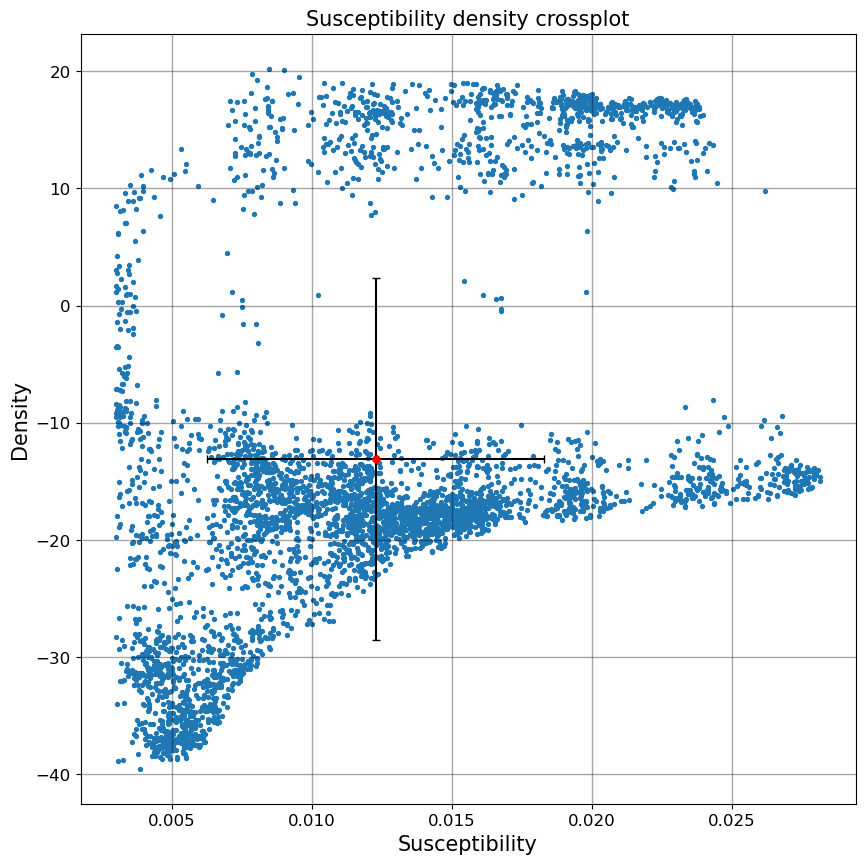

In [35]:
# create figure
figure1 = plt.figure(figsize=(10,10) , facecolor='white')

ax1 = plt.subplot(1, 1, 1)
im1 = plt.scatter(inverted_data_intrusion[:,0],inverted_data_intrusion[:,1] , 8)
ax1.set_title("Susceptibility density crossplot", fontsize=15)
ax1.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax1.set_xlabel('Susceptibility' , fontsize=15)
ax1.set_ylabel('Density' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.errorbar(np.mean(inverted_data_intrusion[:,0]) ,
             np.mean(inverted_data_intrusion[:,1]) ,
             xerr=np.std(inverted_data_intrusion[:,0]) ,
             yerr=np.std(inverted_data_intrusion[:,1]) ,
             fmt='ko' ,
             markersize=5 ,
             markerfacecolor= "red" , 
             markeredgecolor="red" , 
             capsize=3)

# plt.savefig(export_fig_path_histogramms + "sus_dens_intrusion_cross_plot",dpi=300,facecolor=figure2.get_facecolor(), transparent=True)

print(max(inverted_data_intrusion[:,0]))
print(min(inverted_data_intrusion[:,0]))

print(max(inverted_data_intrusion[:,1]))
print(min(inverted_data_intrusion[:,1]))

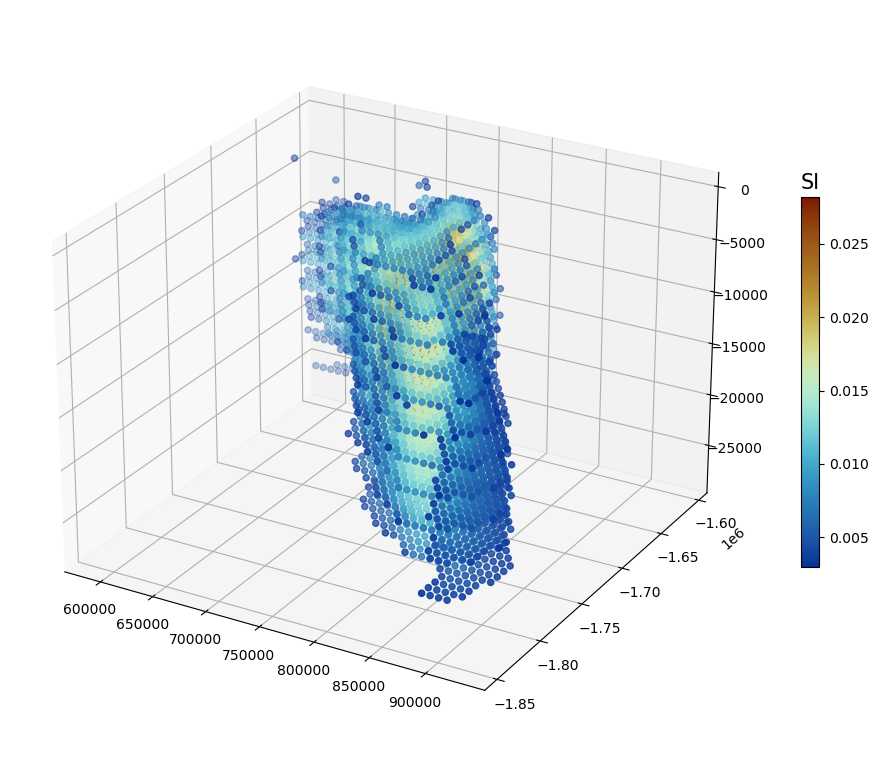

In [36]:
cmap_sus_grav = cm.roma_r

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
im1 = ax.scatter(inverted_data_intrusion[:,2], inverted_data_intrusion[:,3], inverted_data_intrusion[:,4]*-1 ,c=inverted_data_intrusion[:,0],cmap=cmap_sus_grav)
cb = plt.colorbar(im1, shrink=0.4)
cb.ax.set_title('SI',fontsize=m)
axes=plt.gca()
ax.view_init(25, 300)
# plt.savefig(export_fig_path_histogramms + "3D_sutur",dpi=300,facecolor=figure2.get_facecolor(), transparent=True)


In [37]:
inverted_data_sutur_ix = []

for i in range(len(inverted_data_poly2[:,0])):
    if inverted_data_poly2[i,1] >=10:
        inverted_data_sutur_ix.append(inverted_data_poly2[i,:])
        
inverted_data_sutur = np.array(inverted_data_sutur_ix)

np.savetxt(export_data_path+'inverted_data_sutur.txt', inverted_data_sutur , delimiter=',')


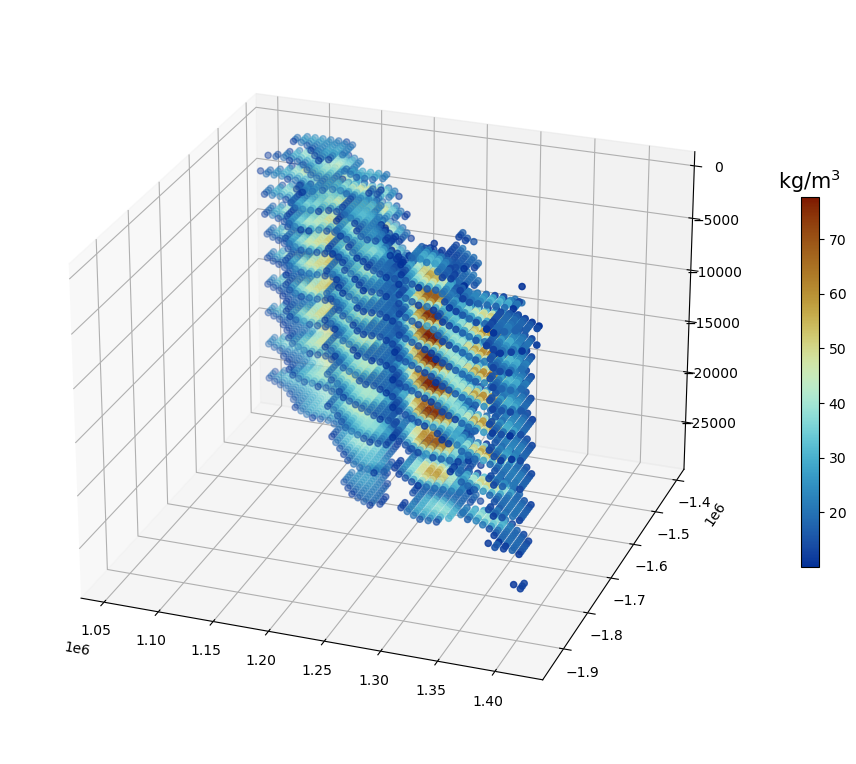

In [38]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
im1 = ax.scatter(inverted_data_sutur[:,2], inverted_data_sutur[:,3], inverted_data_sutur[:,4]*-1 ,c=inverted_data_sutur[:,1],cmap=cmap_sus_grav)
cb = plt.colorbar(im1, shrink=0.4)
cb.ax.set_title(unit_dens,fontsize=m)
axes=plt.gca()
ax.view_init(25, 290)

# plt.savefig(export_fig_path_histogramms + "3D_sutur",dpi=300,facecolor=figure2.get_facecolor(), transparent=True)


In [39]:
sutur_vol_ix =  np.vstack((inverted_data_sutur[:,2], inverted_data_sutur[:,3], inverted_data_sutur[:,4]*-1 )).T

<ErrorbarContainer object of 3 artists>

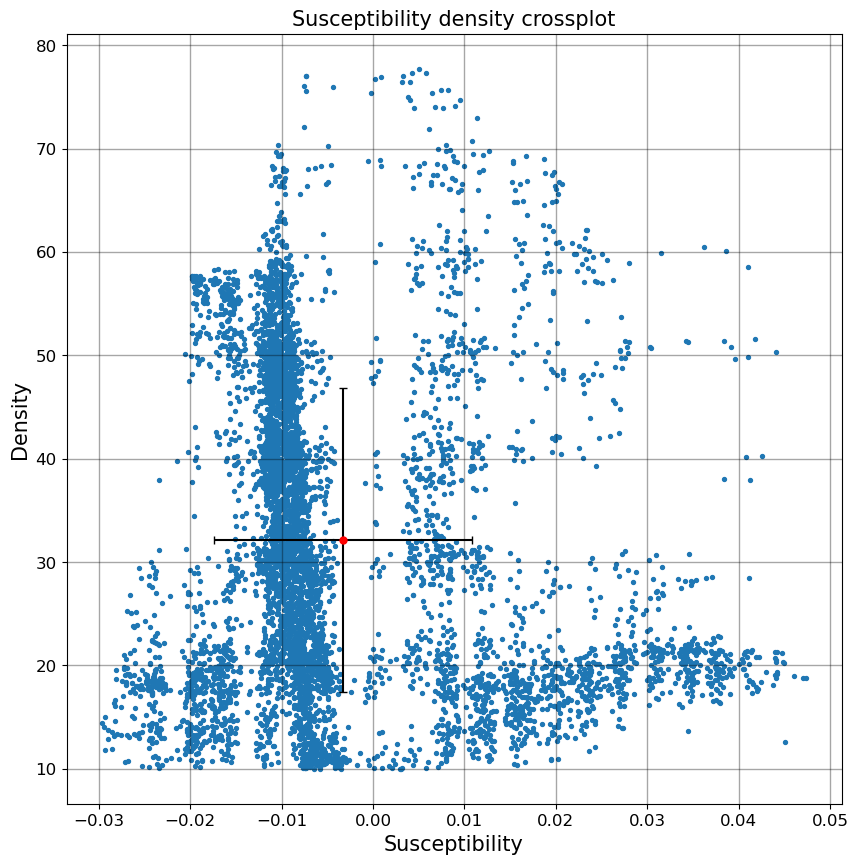

In [40]:
# create figure
figure1 = plt.figure(figsize=(10,10) , facecolor='white')

ax1 = plt.subplot(1, 1, 1)
im1 = plt.scatter(inverted_data_sutur[:,0],inverted_data_sutur[:,1] , 8)
ax1.set_title("Susceptibility density crossplot", fontsize=15)
ax1.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax1.set_xlabel('Susceptibility' , fontsize=15)
ax1.set_ylabel('Density' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.errorbar(np.mean(inverted_data_sutur[:,0]) ,
             np.mean(inverted_data_sutur[:,1]) ,
             xerr=np.std(inverted_data_sutur[:,0]) ,
             yerr=np.std(inverted_data_sutur[:,1]) ,
             fmt='ko' ,
             markersize=5 ,
             markerfacecolor= "red" , 
             markeredgecolor="red" , 
             capsize=3)

# plt.savefig(export_fig_path_histogramms + "sus_dens_sutur_cross_plot",dpi=300,facecolor=figure2.get_facecolor(), transparent=True)


In [41]:
min_sus_std_intrusion =  np.mean(inverted_data_intrusion[:,0]) - np.std(inverted_data_intrusion[:,0])
max_sus_std_intrusion =  np.mean(inverted_data_intrusion[:,0]) + np.std(inverted_data_intrusion[:,0])

min_dens_std_intrusion =  np.mean(inverted_data_intrusion[:,1]) - np.std(inverted_data_intrusion[:,1]) 
max_dens_std_intrusion =  np.mean(inverted_data_intrusion[:,1]) + np.std(inverted_data_intrusion[:,1]) 


print(min_sus_std_intrusion)
print(max_sus_std_intrusion)
print(min_dens_std_intrusion)
print(max_dens_std_intrusion)


min_sus_std_sutur = np.mean(inverted_data_sutur[:,0]) - np.std(inverted_data_sutur[:,0])
max_sus_std_sutur = np.mean(inverted_data_sutur[:,0]) + np.std(inverted_data_sutur[:,0])


min_dens_std_sutur = np.mean(inverted_data_sutur[:,1]) - np.std(inverted_data_sutur[:,1])
max_dens_std_sutur = np.mean(inverted_data_sutur[:,1]) + np.std(inverted_data_sutur[:,1])

print(min_sus_std_sutur)
print(max_sus_std_sutur)
print(min_dens_std_sutur)
print(max_dens_std_sutur)

0.006254250931889581
0.01830816562344906
-28.563852372096196
2.3661756713125683
-0.017432038793284543
0.0108837647755646
17.391493694489732
46.81681213563147


In [42]:
sus_dens_identical_to_poly2_ix = []
for i in range(len(crossplot_data_cleaned[:,0])):
    if crossplot_data_cleaned[i,0] > min_sus_std_sutur  and crossplot_data_cleaned[i,0] < max_sus_std_sutur and crossplot_data_cleaned[i,1] > min_dens_std_sutur and crossplot_data_cleaned[i,1] < max_dens_std_sutur :
        sus_dens_identical_to_poly2_ix.append(crossplot_data_cleaned[i,:])
sus_dens_identical_to_poly2 = np.array(sus_dens_identical_to_poly2_ix)

In [43]:
intrusion_dens_sus_std_ix = []
for i in range(len(inverted_data_intrusion[:,0])):
    if inverted_data_intrusion[i,0] > min_sus_std_intrusion and  inverted_data_intrusion[i,0] < max_sus_std_intrusion and inverted_data_intrusion[i,1] > min_dens_std_intrusion and inverted_data_intrusion[i,1] < max_dens_std_intrusion:
        intrusion_dens_sus_std_ix.append(inverted_data_intrusion[i,:])
intrusion_dens_sus_std = np.array(intrusion_dens_sus_std_ix)

sutur_dens_sus_std_ix = []
for i in range(len(inverted_data_sutur[:,0])):
    if inverted_data_sutur[i,0] > min_sus_std_sutur and  inverted_data_sutur[i,0] < max_sus_std_sutur and inverted_data_sutur[i,1] > min_dens_std_sutur and inverted_data_sutur[i,1] < max_dens_std_sutur:
        sutur_dens_sus_std_ix.append(inverted_data_sutur[i,:])
sutur_dens_sus_std = np.array(sutur_dens_sus_std_ix)

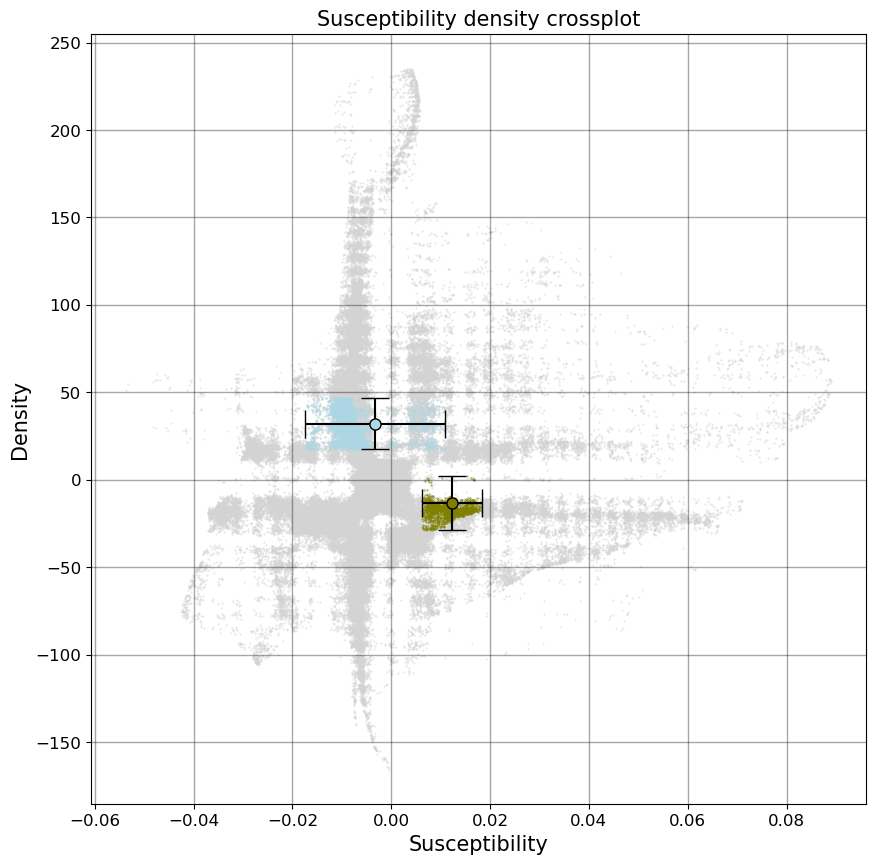

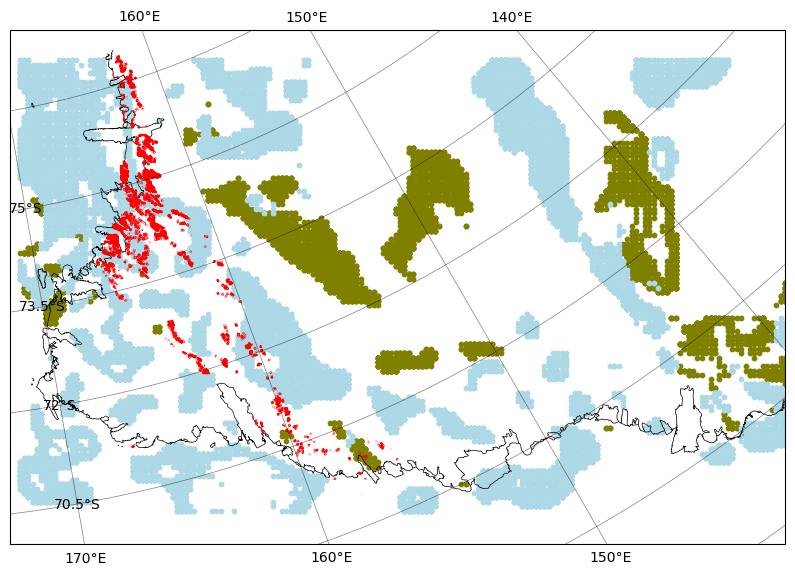

In [44]:
sus_dens_identical_to_poly1_ix = []




for i in range(len(crossplot_data_cleaned[:,0])):

    if crossplot_data_cleaned[i,0] > min_sus_std_intrusion  and crossplot_data_cleaned[i,0] < max_sus_std_intrusion and crossplot_data_cleaned[i,1] > min_dens_std_intrusion and crossplot_data_cleaned[i,1] < max_dens_std_intrusion :
        sus_dens_identical_to_poly1_ix.append(crossplot_data_cleaned[i,:])

sus_dens_identical_to_poly1 = np.array(sus_dens_identical_to_poly1_ix)

# create figure
figure1 = plt.figure(figsize=(10,10) , facecolor='white')

ax1 = plt.subplot(1, 1, 1)
im1 = plt.scatter(crossplot_data_cleaned[:,0],crossplot_data_cleaned[:,1] , 0.1 , c='lightgrey')
ax1.set_title("Susceptibility density crossplot", fontsize=15)
ax1.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax1.set_xlabel('Susceptibility' , fontsize=15)
ax1.set_ylabel('Density' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

im1 = plt.scatter(sutur_dens_sus_std[:,0],sutur_dens_sus_std[:,1] , 0.1 , 'lightblue')
ax1.set_title("Susceptibility density crossplot", fontsize=15)
ax1.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax1.set_xlabel('Susceptibility' , fontsize=15)
ax1.set_ylabel('Density' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax1 = plt.subplot(1, 1, 1)
im1 = plt.scatter(intrusion_dens_sus_std[:,0],intrusion_dens_sus_std[:,1] , 0.1 , 'olive')
ax1.set_title("Susceptibility density crossplot", fontsize=15)
ax1.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
ax1.set_xlabel('Susceptibility' , fontsize=15)
ax1.set_ylabel('Density' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.errorbar(np.mean(inverted_data_intrusion[:,0]) ,
             np.mean(inverted_data_intrusion[:,1]) ,
             xerr=np.std(inverted_data_intrusion[:,0]) ,
             yerr=np.std(inverted_data_intrusion[:,1]) ,
             fmt='ko' ,
             markersize=8 ,
             markerfacecolor= "olive" , 
             markeredgecolor="k" , 
             capsize=10)

plt.errorbar(np.mean(inverted_data_sutur[:,0]) ,
             np.mean(inverted_data_sutur[:,1]) ,
             xerr=np.std(inverted_data_sutur[:,0]) ,
             yerr=np.std(inverted_data_sutur[:,1]) ,
             fmt='ko' ,
             markersize=8 ,
             markerfacecolor= "lightblue" , 
             markeredgecolor="k" , 
             capsize=10)


figure2 = plt.figure(figsize=(10,10) , facecolor='white')
ax2 = plt.subplot(1, 1, 1 ,  projection=ccrs.SouthPolarStereo())
Coastline.plot(ax=ax2 , color = 'k', linewidth=.5)
ax2.scatter(sus_dens_identical_to_poly1[:,2] , sus_dens_identical_to_poly1[:,3] , 10 , c='olive',transform=ccrs.SouthPolarStereo())
ax2.scatter(sus_dens_identical_to_poly2[:,2] , sus_dens_identical_to_poly2[:,3] , 10 , c='lightblue',transform=ccrs.SouthPolarStereo())
GHI_wsb.boundary.plot(ax=ax2 , color='red')
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=0.5, linestyle='-' , rotate_labels=0)
ax2.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())